# Solution to Exercise 5 from the IBM Quantum Challenge 2021 by Jakub Mrozek

The fifth exercise of the challenge was about the algorithm known as Variational Quantum Eigensolver and using it to approximate the ground state energy of LiH molecule. The goal of this exercise is to find an ansatz that approximates the actual solution in fewest possible CNOT gates. <br>
We were able to modify the existing code and to try many different settings, and each time check how close it comes to the accepted ground state energy. It is quite clear that our final solution will be a product of some kind of "feedback loop" implicitly looking at the ground state eigenstate and trying to approximate it. Even if you don't manually inspect the actual ground state, it is still guiding the "evolution" of your solution, in similar manner in which natural selection, an unconsious process, guides evolution in nature. <br>
With this in mind, let's import a driver and define our molecule and then check that everything is correct.

In [2]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [6]:
n_el = qmolecule.num_alpha + qmolecule.num_beta

n_mo = qmolecule.num_molecular_orbitals

n_so = 2 * qmolecule.num_molecular_orbitals

e_nn = qmolecule.nuclear_repulsion_energy

print("Number of electrons: {0}".format(n_el))
print("Number of molecular orbitals: {0}".format(n_mo))
print("Number of spin-orbitals: {0}".format(n_so))
print("Nuclear repulsion energy: {0}".format(e_nn))

Number of electrons: 4
Number of molecular orbitals: 6
Number of spin-orbitals: 12
Nuclear repulsion energy: 1.0259348796432726


We know from chemistry that H has one electron, sitting in a 1s orbital, and Li has 3 electrons, two in the 1s orbital and the last one in the 2s orbitals. For Li, the 2p orbitals are also possible, and there are three of them, $p_x, p_y$ and $p_z$. That gives the total of 6 (1+5). Each of those can contain a spin up or spin down electron, so the total number of spin-orbitals is 12. It seems like the driver successfully created the molecule. 

The problem can be cleanly split in half. The first half is trying to get as few qubits as possible while still having the ground state inside or just slighly outside your state space. After modifying the qubits, utilizing symmetries, freezing the core and all that, we have a quantum system with n spins and a certain Hamiltonian. If the ground state energy of that quantum system is too high, there is no point making ansatzes/choosing optimizers - there are no legal ways of getting to lower than the lowest eigenenergy, it's just how linear algebra works. If, on the other hand, our energy is within bounds, then there must exist a quantum circuit that gets us to the eigenstate, based on universality. So really we don't have to bother about ansatz or optimizers at all in this first part.

The LiH has axial symmetry. The Li 1s orbital has core electrons which shouldn't form the bond. The ground state of this molecule is a sigma bond, where electrons from H 1s and Li 2s orbitals mostly interact. Because of symmetry, you also allow some mixing with $p_z$ (if $z$ is in the direction of the axis between H and Li). This is of course some prior quantum chemistry knowledge, but not very advanced. Therefore it makes sense that you should be able to freeze the core and remove two orbitals ($p_x, p_y$) that do not contribute to the ground state. I could have checked which numbers correspond to $p_x$ and $p_y$ but it was faster to just run it and see how the exact energy changes, also confirming that I was (probably) right here. Those were orbitals 3 and 4.

In [7]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer
freezeCoreTransformer = FreezeCoreTransformer(True,[3,4])
problem = ElectronicStructureProblem(driver, q_molecule_transformers=[freezeCoreTransformer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

Furthermore, I decided to try the 2 qubit reduction setting, even though I still don't fully get how it works exactly. It would perhaps be more evident if I had read something explicit about the Parity Mapper. But it did work, ie. checking this option didn't mess the exact energy up.

In [8]:
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

mapper = ParityMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

We were required by this challenge to start with the Hartree-Fock state so let us do just that

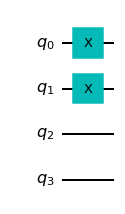

In [9]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
init_state.draw('mpl')

It is at this point where we need to check if the exact ground state energy is correct. The exact result is $-8.90847$ Ha and we can be off by $0.004$ Ha, but it is safe to leave most of this margin to the optimizer/ansatz to deal with, it would be perfect if we still had close to the exact ground state energy at this point. It can only be higher, if it is lower it means we played with some wrong parameters or generally messed something up. If it is higher, it means we removed the actual ground state from the state space, but it probably sits just outside. We should still be able to approximate it using the VQE.

In [10]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.0887060157347381
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


Great, we have $-8.90739$ Ha, which is off by $0.00108$ Ha, not terrible. We still have a margin of about $0.003$ Ha to work with.

Because of dimensionality of separable and entangled Hilbert spaces it is a good heuristic to realize that the eigenstate, whatever it is, is likely to be fully entangled. So each spin had to be connected to each other somehow, what requires $n-1$ CNOTs on $n$ qubits. Also, if you take a step back and think in terms of the second quantization operators, they tell you how many electrons are in each state, but the total number of valence electrons is 2. So you are more likely to have superpositions like $|01 \rangle+|10\rangle$ (entangled) rather than $|00 \rangle+|10\rangle$ (not entangled). Even though of course this is just an approximation at this point. This is of course because you would expect that if the electron is not in, say, the 2s Li orbital, then it is somewhere else, for example in the $p_z$ orbital. The "0"s correspond to the electron not being there and "1"s to the electron being there. <br>
Either way, we expect the state to be highly entangled. With 4 qubits, we need at least 3 CNOTs. What would be a systematic approach to the ansatz to see if 3 qubits can work?<br>
First, let's do a full layer of parametrized rotations. Then, introduce the CNOTs in some order, following each CNOT up with parametrized rotations on affected qubits. I later removed this as it wasn't necessary and reduced the number of parameters, and instead just did another full layer of rotations at the end. How many ways are there to introduce those 3 CNOTs? Well, we need to "connect" all the qubits, but we have the full layers of rotations anyway, and they can be used to invert the roles of target and control on a CNOT anyway, so there is no point considering, say, CNOT acting on the qubit 2 controlled by 1 and the CNOT acting on the qubit 1 controlled by 2 separately. The rotations are going to get different parameters and turn one into another anyway. So for the CNOTs it only matters which qubits they connect. <br>
How many ways of placing them are there? First, pick two qubits and do a CNOT between them. We can choose in ${4 \choose 2} = 6$ ways. Then, we can just do another CNOT between the two other qubits, and then the third one that connects one of the two selected in the first step to one of the two others. There are $4$ ways to do this as we select one of the $2$ twice. $24$ ways in total. Alternatively, the second CNOT connects one of the already entangled qubits with one of the other $2$, what gives $4$ possibilities, and the last one connects the last qubit to either of the other $3$, what gives $3$ possibilities. That is $72$ possibilities and a grand total of $96$ ways to order these $3$ CNOTs. We can just check all of them systematically but I only needed to get through about $12$ until I found one that worked:

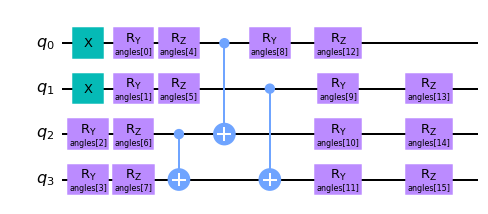

In [11]:
# Choose the ansatz
ansatz_type = "Custom"

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister

n = qubit_op.num_qubits
    
# Define the variational parameters
    
angles = {}
for i in range(4*n):
    angles[i] = Parameter('angles[{0}]'.format(i))
    
# Make an empty quantum circuit
qc = QuantumCircuit(qubit_op.num_qubits)
    
#rotations
for i in range(n):
    qc.ry(angles[i],i)
    qc.rz(angles[i+n],i)
    
# Place CNOTs
qc.cx(2,3)
qc.cx(0,2)
qc.cx(1,3)
    
#second layer
for i in range(n):
    qc.ry(angles[2*n+i],i)
    qc.rz(angles[3*n+i],i)
    
ansatz = qc
ansatz.compose(init_state, front=True, inplace=True)

ansatz.draw(output='mpl')

Now, let us get the backend and the optimizer and finish the job.

In [12]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

In [13]:
from qiskit.algorithms.optimizers import SLSQP

optimizer_type = 'SLSQP'
optimizer = SLSQP(maxiter=1000)

In [14]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 701,
    'eigenstate': array([-1.98497086e-05-6.10021405e-06j, -8.40207380e-04-9.32161344e-05j,
        3.59776293e-02-5.97029555e-03j,  9.81156102e-01-1.37815772e-01j,
        6.85243554e-04-1.50703514e-04j,  1.85041291e-05-1.37765766e-06j,
       -2.27207188e-02+3.27279229e-03j, -1.70429527e-02+1.23138660e-03j,
       -1.79635129e-03+3.56109623e-04j,  2.23921539e-03-1.03949959e-03j,
        1.16642953e-03-2.33575547e-04j,  4.84963797e-03+2.93262732e-04j,
       -1.11358155e-01+1.50822200e-02j, -7.79333319e-04+6.01217355e-04j,
        5.85691192e-02-9.76025278e-03j,  2.99031188e-04-3.32702822e-04j]),
    'eigenvalue': -1.0867024549370703,
    'optimal_parameters': {   Parameter(angles[8]): 1.5413314816526815,
                              Parameter(angles[9]): 1.08457192806228,
                              Parameter(angles[10]): 1.5366172291219762,
                              Parameter(angles[11]): 1.5829644902755327,

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,SLSQP,QuantumCircuit,4,16,None,None,None,None,2.003561,True,3


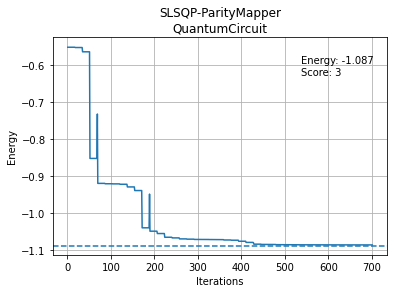

In [15]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_hli.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

The calculated value is $2.004$ mHa away from the result of the exact eigensolver, which was $1.08$ mHa away from the accepted value, so in total this result is $3.084$ mHa too high, which is within bounds of $4$ mHa.